# 演習その３ Diffusionモデルを動作させる

In [1]:
import argparse
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
from scipy.io.wavfile import write

import torch

# For Grad-TTS
import params
from model import GradTTS
from text import text_to_sequence, cmudict
from text.symbols import symbols
from utils import intersperse

from model.utils import sequence_mask, generate_path, duration_loss, fix_len_compatibility

# For HiFi-GAN
import sys
sys.path.append('./hifi-gan/')
from env import AttrDict
from models import Generator as HiFiGAN

# 1.モデルのロード

In [2]:
# CMUDictのロード
cmu = cmudict.CMUDict('./resources/cmu_dictionary')

# GradTTSのロード
N_SPKS = 1
generator = GradTTS(len(symbols)+1, N_SPKS, params.spk_emb_dim,
                    params.n_enc_channels, params.filter_channels,
                    params.filter_channels_dp, params.n_heads, params.n_enc_layers,
                    params.enc_kernel, params.enc_dropout, params.window_size,
                    params.n_feats, params.dec_dim, params.beta_min, params.beta_max,
                    pe_scale=1000)  # pe_scale=1 for `grad-tts-old.pt`
# generator.load_state_dict(torch.load('./checkpts/grad-tts-libri-tts.pt', map_location=lambda loc, storage: loc))
generator.load_state_dict(torch.load('./checkpts/grad-tts.pt', map_location=lambda loc, storage: loc))
_ = generator.cuda().eval()
print(f'Number of parameters: {generator.nparams}')

# HiFiGAN
with open('./checkpts/hifigan-config.json') as f:
    h = AttrDict(json.load(f))
hifigan = HiFiGAN(h)
hifigan.load_state_dict(torch.load('./checkpts/hifigan.pt', map_location=lambda loc, storage: loc)['generator'])
_ = hifigan.cuda().eval()
hifigan.remove_weight_norm()
%matplotlib inline

Number of parameters: 14835032
Removing weight norm...


# 2.Encoderによる初期分布の計算

## 2.1. Encoderで終端分布$N(\mu, I)$の平均$\mu$を計算する

In [14]:
text = "Hello. I am an artificial intelligence for voice generation."

In [15]:
x = torch.LongTensor(intersperse(text_to_sequence(text, dictionary=cmu), len(symbols))).cuda()[None]
x_lengths = torch.LongTensor([x.shape[-1]]).cuda()

In [18]:
temperature=1.0
length_scale=1.0

mu_x, logw, x_mask = generator.encoder(x, x_lengths)

w = torch.exp(logw) * x_mask
w_ceil = torch.ceil(w) * length_scale
y_lengths = torch.clamp_min(torch.sum(w_ceil, [1, 2]), 1).long()
y_max_length = int(y_lengths.max())
y_max_length_ = fix_len_compatibility(y_max_length)

# Using obtained durations `w` construct alignment map `attn`
y_mask = sequence_mask(y_lengths, y_max_length_).unsqueeze(1).to(x_mask.dtype)
attn_mask = x_mask.unsqueeze(-1) * y_mask.unsqueeze(2)
attn = generate_path(w_ceil.squeeze(1), attn_mask.squeeze(1)).unsqueeze(1)

# Align encoded text and get mu_y
mu_y = torch.matmul(attn.squeeze(1).transpose(1, 2), mu_x.transpose(1, 2))
mu_y = mu_y.transpose(1, 2)

# Sample latent representation from terminal distribution N(mu_y, I)
z = mu_y + torch.randn_like(mu_y, device=mu_y.device) / temperature

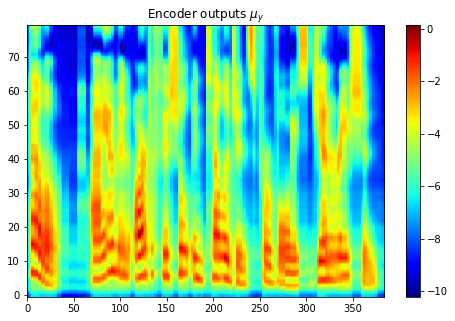

In [19]:
plt.figure(figsize=(8,5))
plt.title('Encoder outputs $\mu_y$')
plt.imshow(mu_y.detach().cpu().squeeze(), aspect='auto', origin='lower', cmap="jet")
plt.colorbar()

with torch.no_grad():
    audio = hifigan.forward(mu_y).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))

## 2.2. 終端分布$N(\mu, I)$から初期値$X_T$をサンプリングする

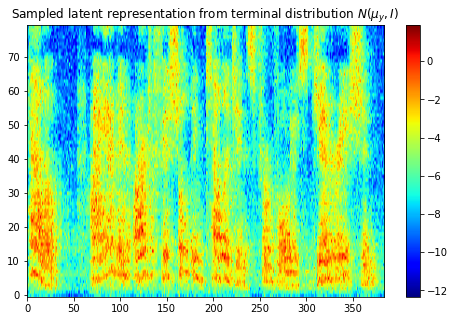

In [20]:
z = mu_y + torch.randn_like(mu_y, device=mu_y.device)

plt.figure(figsize=(8,5))
plt.title('Sampled latent representation from terminal distribution $N(\mu_y, I)$')
plt.imshow(z.detach().cpu().squeeze(), aspect='auto', origin='lower', cmap="jet")
plt.colorbar()

with torch.no_grad():
    audio = hifigan.forward(z).cpu().squeeze().clamp(-1, 1)
ipd.display(ipd.Audio(audio, rate=22050))

# 3. Decoderによるデノイジング

## 3.1. Reverse diffusionの実行

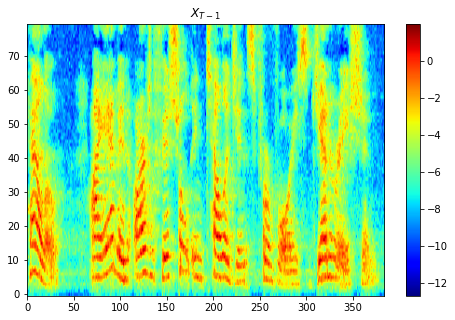

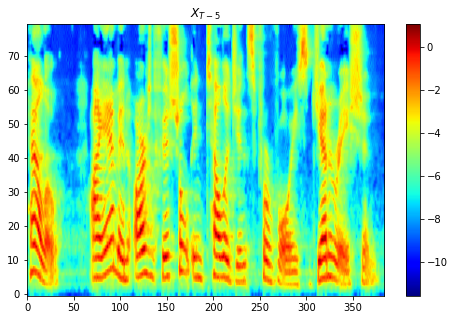

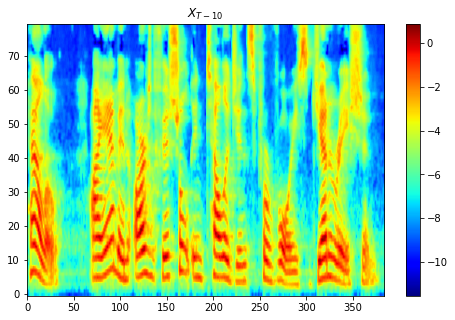

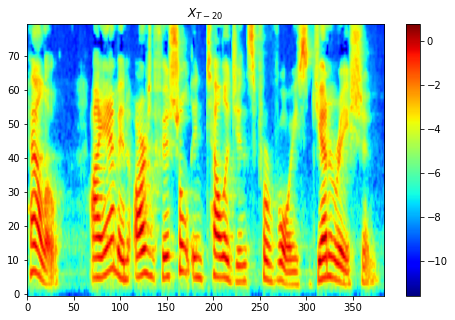

In [21]:
for n_timesteps in [1, 5, 10, 20]:
    decoder_outputs = generator.decoder(z, y_mask, mu_y, n_timesteps)
    plt.figure(figsize=(8,5))
    plt.title("$X_{T-%d}$"%(n_timesteps))
    plt.imshow(decoder_outputs.detach().cpu().squeeze(), aspect='auto', origin='lower', cmap="jet")
    plt.colorbar()
    
    with torch.no_grad():
        audio = hifigan.forward(decoder_outputs).cpu().squeeze().clamp(-1, 1)
    ipd.display(ipd.Audio(audio, rate=22050))